# Project: No Show Appointments Analysis
<a id="top"></a>

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#general_properties">General Properties</a></li>
        <li><a href="#actions_plan">Actions Plan</a></li>
        <li><a href="#cleaning">Data Cleaning</a></li>
    </ul>
    </li>
<li><a href="#eda">Exploratory Data Analysis</a>
    <ul>
        <li><a href="#overview">0. Overview</a></li>
        <li><a href="#gender">1. What gender is more likely to skip the appointment: men or women?</a></li>    
        <li><a href="#daysbefore">2. What is the average number of days between the scheduling and actual appointment in both groups?</a></li>
        <li><a href="#conditions">3. What condition (Hipertension, Diabetis, Alcoholism) has the lowest number of no-shows?</a></li>
        <li><a href="#age_groups">4. What age groups have the lowest/highest rate of no shows?</a></li>
        <li><a href="#cond_age">5. What conditions dominate in different age groups?</a></li>
        <li><a href="#additional">Additional exploration: alcoholism in age group 0-14? Scary observations</a></li>
    </ul>
    </li>
    
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
<a href="#top">Back to Top</a>

This dataset contains the records from 110,527 medical appointments in Brazil. The dataset describes different characteristics of each appointment (rather than of each patient):  
- PatientId  
- AppointmentId 
- Gender 
- ScheduledDay &mdash; the day when the patient scheduled their appointment 
- AppointmentDay 
- Age
- Neighbourhood &mdash; the location of the hospital 
- Scholarship &mdash; 1 if the patient is enrolled into Brazilian welfare program Bolsa Familia. 
- Hipertension, Diabetis, Alcoholism, Handcap
- SMS_received &mdash; whether a patient received an SMS before the appointment 
- No-show &mdash; No if the patient DID show up at the scheduled day, yes if he didn't. 

The goal is to explore what factors influence if the patient shows up for their appointment. The variable of interest is <b>binary</b>, so we can't simply make a scatter plot to check for relationship between other variables and the variable of interest. What we can do is to compare the distributions of attribute values for two groups - when the patient showed up and when he didn't show up. I.e. - how do these groups differ? 

In this sense it would be interesting to investigate the following:  
1) What gender is more likely to skip the appointment: men or women?   
2) What is the average number of days between the scheduling and actual appointment in both groups?   
3) What conditions (Hypertension, Diabetis, Alcoholism) have the lowest number of no-shows?   
4) What age groups have the lowest/highest number of no shows?    

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling
<a id="general_properties"></a>
### General Properties  

<a href="#top">Back to Top</a>

In [2]:
df = pd.read_csv('no_show_dataset.csv')

First of all, we need to check our dataset to make sure that we don't have missing values, that entries are valid and that we have appropriate encoding for all the variables. 

In [3]:
df.head(3) 

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<a id="#actions_plan"></a>
### Actions Plan 
<a href="#top">Back to Top</a>


We can see that there are no null values in the data set, so we don't have to do anything about it. However, there are several things that can improve our analysis: 
- convert PatientID to str. We don't need that data for this analysis, but I think it's a good idea to have a clean dataset. ID is not something we need to add/subtract/multiply, so it is better to store it as a string. 
- convert ScheduledDay and AppointmentDay to datetime objects so that we can find the delta between them. 
- create additional column with age bins
- exclude Handcap (meaning is unclear)

Now, let's check for any inconsistencies in the data by looking at the dataset summary: 

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


We might notice a very weird thing here - there is age -1. We expect that age is strictly positive number. If we check the dataset, we will see that there is only one record with age -1. It looks more like a human error so we should drop this row. 

In [6]:
df[df.Age==-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


<a id="cleaning"></a>
### Data Cleaning

<a href="#top">Back to Top</a>

#### Remove invalid age 

In [7]:
# drop invalid row
df = df.drop(df[df.Age==-1].index)

#### Convert patient and appointment ids to strings

In [8]:
df.PatientId = df.PatientId.astype('int').astype('str')
df.AppointmentID = df.AppointmentID.astype('str')

#### Convert ScheduledDay and AppointmentDay to date

This one is rather tricky. Since I want to count the number of days between the day the appointment was scheduled and the day of the actual appointment, I want to be able to subtract one from another. However, I noticed, that for the AppointmentDay the time is always 00:00:00. To prove that, we can select all unique values for the hour of the appointment, we will get zero: 

In [9]:
(pd.to_datetime(df.AppointmentDay)).apply(lambda x: x.hour).unique()

array([0])

I decided to create additional column to store ScheduledDate because we might want to analyse the time of the day when the appointment was scheduled some time in the future, so we don't want to delete that completely. 

In [10]:
df['ScheduledDateTime'] = pd.to_datetime(df.ScheduledDay)
df['ScheduledDay'] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.date())
df['AppointmentDay'] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.date())

#### Create column for days between scheduling and actual appointment

Now we can create yet another column to store days between the scheduling date and the appointment date:

In [11]:
df['DaysBetween'] = (df.AppointmentDay - df.ScheduledDay).apply(lambda x: x.days)

One thing to check here is whether the data makes sense for all the records: i.e. we can't schedule the appointment AFTER the appointment date, so the date or scheduling should be less or equal to the appointment date. If this is not true, we should drop these records. 

In [12]:
df[df.DaysBetween<0][['ScheduledDay','AppointmentDay','DaysBetween']]

,ScheduledDay,AppointmentDay,DaysBetween
27033,2016-05-10,2016-05-09,-1
55226,2016-05-18,2016-05-17,-1
64175,2016-05-05,2016-05-04,-1
71533,2016-05-11,2016-05-05,-6
72362,2016-05-04,2016-05-03,-1


In [13]:
# actually drop these rows
df = df.drop(df[df.DaysBetween<0].index)

#### Creating age bins

Let's first explore the age column more closely

In [14]:
df.Age.describe()

count    110521.000000
mean         37.089386
std          23.109885
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

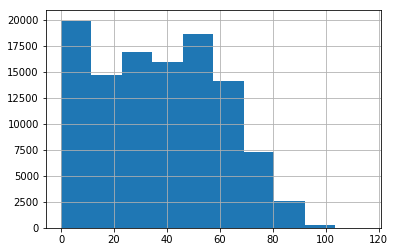

In [15]:
df.Age.hist();

It might look reasonable to create age bins based on quartiles. However, in this case it makes more sense to use more 'natural' categories. The following bin edges were set after several experiments with question 4 to better describe the distribution of ages. 

In [16]:
bin_edges = [0, 14, 18, 25, 35, 55, 75, 85,115]
bin_names = ['0-14','15-18','19-25','26-35','36-55','56-75', '76-85','86-115']
df['Age_group'] = pd.cut(df.Age, bin_edges, labels=bin_names)

In [17]:
df.drop(labels=['Handcap'], inplace=True, axis=1)

In [18]:
#### Encode no-show

In [19]:
df['No-show']=df['No-show']=='Yes'

<a id='eda'></a>
## Exploratory Data Analysis

<a id='overview'></a>
### 0. Data Overview

<a href="#top">Back to Top</a>

The first step is to take a look at now clean dataset and identify its properties: 

In [20]:
df.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,DaysBetween
count,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000
mean,37.089386,0.098271,0.197257,0.071869,0.030401,0.321043,10.184345
std,23.109885,0.297682,0.397929,0.258272,0.171690,0.466879,15.255153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000


Some observations: 
- Only 9.8% of the appointments were made by the patients receiving a scholarship 
- 20% of the appointment were made by the patients with hypertension 
- Only 7% of the appointments were made by people with diabetes 
- 3 % of the appointments were made by people suffering from alcoholism
- For 32% of the appointments there was sent an SMS reminder 
- 50% of the appointments were scheduled no more than 4 days in advance 
- The earliest appointment was made 179 days prior!

<a id='gender'></a>
### 1. What gender is more likely to skip the appointment: men or women?  
<a href="#top">Back to Top</a>

In order to compare that we want to calculate total number and percentage of not shows: 

In [21]:
total_no_show = sum(df['No-show'])
total_show = len(df)-total_no_show

In [22]:
print("With the total of {} appointments, there were {} no shows, which is {} from the total".format(len(df), 
                                                                                total_no_show, 
                                                                                round(total_no_show/len(df),2)))
print("{}% of the appointments were made by women".format(round(100*sum(df.Gender=='F')/len(df),2)))

With the total of 110521 appointments, there were 22314 no shows, which is 0.2 from the total
65.0% of the appointments were made by women


In the next step we will calculate the % of no-shows in two groups: males and females. 

In [23]:
gender_groups = df[['No-show','Gender','AppointmentID']].groupby(['No-show','Gender'], as_index=False).count()

In [24]:
gender_groups.rename(columns={'AppointmentID':'counts'},inplace=True)
totals = gender_groups.groupby('Gender').sum()
no_show_rate_gender= gender_groups[gender_groups['No-show']][['Gender','counts']].set_index('Gender').divide(totals)

In [25]:
def bar_plot_by_index(df,column_name,title="", size=(8,4)):
    width=0.35
    ind = np.array(range(len(df.index)))
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    red_bars = ax.bar(ind, df[column_name], width=width, color='cadetblue');
    labels = list(df.index)
    plt.xticks(ind, labels, rotation=45);
    plt.title(title);

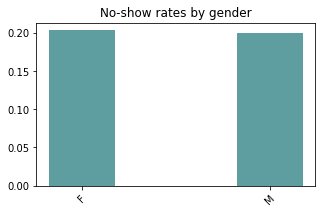

In [26]:
bar_plot_by_index(no_show_rate_gender, 'counts', 'No-show rates by gender', (5,3))

So, it looks like gender doesn't have any influence on whether the patient will show up on the scheduled day, and there are more important factors that influence that.

<a id='daysbefore'></a>
### 2. What is the average number of days between the scheduling and actual appointment in both groups?

<a href="#top">Back to Top</a>

#### General picture

First, let's look at when people typically schedule there appointments (in terms of number of days prior to the appointment): 

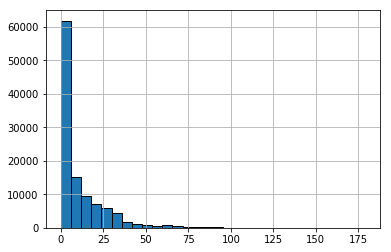

In [27]:
df.DaysBetween.hist(edgecolor='black', bins=30);

In [28]:
df.DaysBetween.describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: DaysBetween, dtype: float64

####  T-test for the means

Average number of days before the actual appointment for those who didn't show up: 

In [29]:
mu1 = df[df['No-show']].DaysBetween.mean()
mu1

15.835484449224701

With SD:

In [30]:
std1 = df[df['No-show']].DaysBetween.std()
std1

16.605599528659894

Average number of days before the actual appointment for those who showed up:

In [31]:
mu2 = df[~(df['No-show'])].DaysBetween.mean()
mu2

8.754758692620767

With SD:

In [32]:
std2 = df[~(df['No-show'])].DaysBetween.std()
std2

14.550450447862671

Here, we should check how significant this difference is. We need to make several assumptions here: 
- two populations have the same variance
- populations are normally distributed
- values are independent

The null hypothesis is that the difference between the population means is 0. First, we calculate the statistic: 

In [33]:
mu1-mu2

7.080725756603934

Calculate n1 and n2

In [34]:
n1 = len(df[df['No-show']])
n2 = len(df[~(df['No-show'])])

We set $\alpha = .05$, then we should reject H0 if z-score < -1.96 or z-score > +1.96.

$$z=\frac{(\bar{x_1}-\bar{x_2}) - (\mu_1-\mu_2) }{\sqrt{  \frac{\sigma_1^2}{n_1} +\frac{\sigma_2^2}{n_2}}} =
\frac{(15.8-8.8) - 0 }{\sqrt{  \frac{16.6^2}{22314} +\frac{14.6^2}{88207}}}
$$

In [35]:
(mu1-mu2)/((std1**2)/n1+(std2**2)/n2)**(1/2)

58.286475071649335

We have to reject the null hypothesis since 58 is far outside of the confidence interval. We can conclude, that the number of days between scheduling and actual appointment indeed make difference.

#### Visualisations

Lastly, we want to plot this difference. In this case, a boxplot looks like an appropriate way to compare the two samples visually.

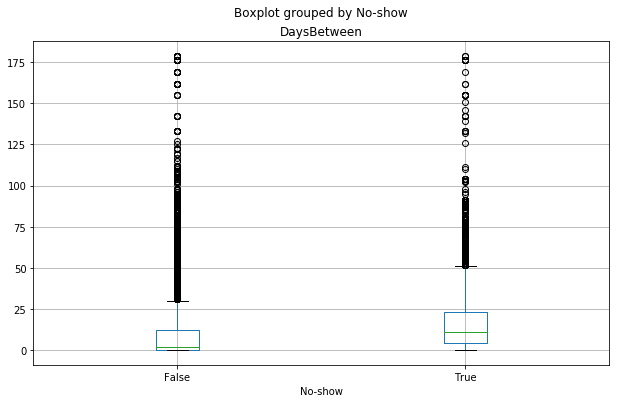

In [36]:
df.boxplot(column='DaysBetween',by='No-show',figsize=(10,6));

<a id='conditions'></a>
### 3. What condition (Hipertension, Diabetis, Alcoholism) has the lowest number of no-shows?  

<a href="#top">Back to Top</a>

The first thing to check is whether all these events are disjoint or we have patients that have 2 or even all 3 of these conditions. 

In [37]:
more_than_one_condition_sel = (df.Hipertension+df.Diabetes+df.Alcoholism)>1
round(100*sum(more_than_one_condition_sel)/len(df),2)

6.91

7% of the patients have more than one condition. It's a large enough group, and I decided to make it a separate group, so in the end we have: 
- people with alcoholism
- people with hypertension
- people with diabetes
- people with more than one condition
- people without any of these conditions

For this last group it also makes sense to check what conditions are combined most of the time. Since we're comparing only 3 conditions we can have only 3 pairs (because $\binom{C}{k}$). So, for various combinations of conditions we have the following percentages: 

In [38]:
print('Hypertension and Diabetes: {}\nHypertension and Alcoholism: {} \nDiabetes and Alcoholism: {}\nAll three: {}'.
      format(round(100*sum((df.Hipertension+df.Diabetes)>1)/sum(more_than_one_condition_sel),2),
             round(100*sum((df.Hipertension+df.Alcoholism)>1)/sum(more_than_one_condition_sel),2),
             round(100*sum((df.Diabetes+df.Alcoholism)>1)/sum(more_than_one_condition_sel),2),
             round(100*sum((df.Diabetes+df.Alcoholism+df.Hipertension)>2)/sum(more_than_one_condition_sel)),2))

Hypertension and Diabetes: 84.97
Hypertension and Alcoholism: 17.39 
Diabetes and Alcoholism: 4.35
All three: 3


The major group in the group of people with more than one condition is 'hypertension + diabetes'. However, here we will not break these into separate groups, but we'll just keep this in mind if we find something interesting in the general group. 
First, we need to encode the data to make the groupings and counts easier: 

In [39]:
df['conditions']=None

In [40]:
# encode conditions and make all the groups disjoint
df.loc[(df.Diabetes==1)&(~more_than_one_condition_sel),'conditions']='diabetes'
df.loc[(df.Hipertension==1)&(~more_than_one_condition_sel),'conditions']='hypertension'
df.loc[(df.Alcoholism==1)&(~more_than_one_condition_sel),'conditions']='alcoholism'
df.loc[more_than_one_condition_sel,'conditions']='combo'
df.loc[df.conditions.isnull(),'conditions']='other'

In [41]:
groups = df[['conditions','No-show','AppointmentID']].groupby(['conditions','No-show'], as_index=False).count()
groups.rename(columns={'AppointmentID':'counts'},inplace=True)

In [42]:
totals = groups.groupby('conditions').sum()

In [43]:
no_show_rate_cond= groups[groups['No-show']][['conditions','counts']].set_index('conditions').divide(totals)

In [44]:
def bar_plot_by_index(df,column_name,title=""):
    width=0.35
    ind = np.array(range(len(df.index)))
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    red_bars = ax.bar(ind, df[column_name], width=width, color='cadetblue');
    labels = list(df.index)
    plt.xticks(ind, labels, rotation=45);
    plt.title(title);
    

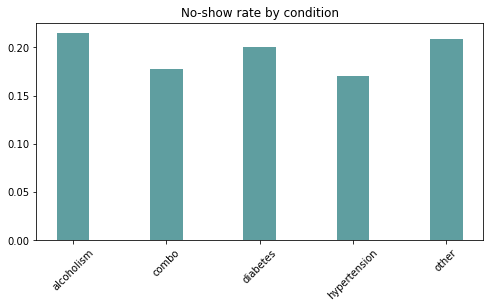

In [45]:
bar_plot_by_index(no_show_rate_cond, 'counts', 'No-show rate by condition')

<b>Observations</b>:  
People with the combination of conditions and with hypertension are just slightly less likely to skip their appointment, whereas for the other groups the rates are quite similar. However, this difference doesn't looks too big, so this factor is likely to have very weak relationship to showing/not showing up. 

<a id='age_groups'></a>
### 4. What age groups have the lowest/highest rate of no shows?    
<a href="#top">Back to Top</a>

In [46]:
age_groups = df[['Age_group','No-show','AppointmentID']].groupby(['Age_group','No-show'], as_index=False).count()
age_groups.rename(columns={'AppointmentID':'counts'},inplace=True)
age_totals = age_groups[['Age_group','counts']].groupby('Age_group').sum()
no_show_rate = age_groups[age_groups['No-show']][['Age_group','counts']].set_index('Age_group').divide(age_totals)
no_show_rate

,counts
Age_group,
0-14,0.217376
15-18,0.253343
19-25,0.253725
26-35,0.227853
36-55,0.197048
56-75,0.155255
76-85,0.159300
86-115,0.168103


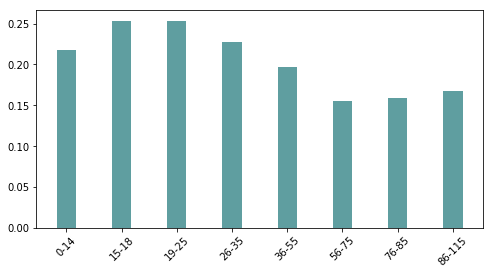

In [47]:
bar_plot_by_index(no_show_rate, 'counts')

<b>Observations</b>:  
Younger people tend to show higher no-show rate - maybe this is due to the fact, that the period from 15 to 35 is the period when people have the most active life and when they are healthy. So, they can care less about their health. So, this variable can be in some relationship with the outcome variable. 

<a id='cond_age'></a>
### 5. What conditions dominate in different age groups? 
<a href="#top">Back to Top</a>

Another thing that got me interested is whether there is a difference in what diseases dominate among people from different age groups, so I decided to create yet another visualisation to explore that. The best way to compare age groups is to create a bar plot where for each age group we would be able to see the % of patients with certain disease (or combo). We don't consider "other" conditions since it's not informative (we yet must keep in mind that this is the majority of the patients.

In [48]:
# here we select columns and make the necessray groupings
# IMPORTANT: here we count number of unique patients per groupt rather than the number of appointments
df_g = df[['Age_group','conditions','PatientId']].groupby(['Age_group','conditions'], as_index=False).agg(lambda x: x.nunique())

In [49]:
# pivot table to use conditions as columns 
df_g = df_g.pivot(index = 'Age_group', columns = 'conditions', values='PatientId').fillna(0).drop('other',axis=1)

In [50]:
# calculate totals for each age group
totals = df_g.sum(axis=1)

In [51]:
# divide each column by the totals, so that we have relative numbers
df_g=df_g.divide(totals,axis=0)*100

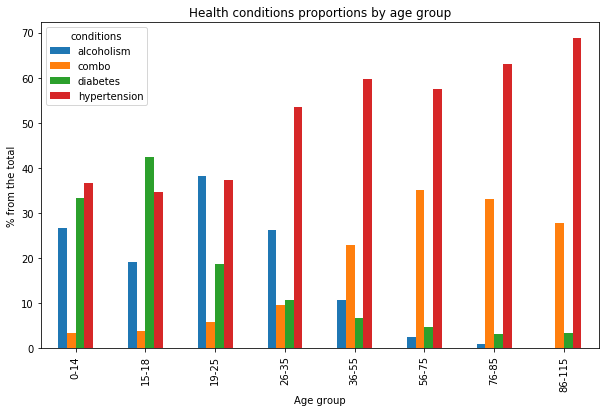

In [52]:
# create bar plot
df_g.plot.bar(figsize=(10,6));
plt.title("Health conditions proportions by age group");
plt.xlabel("Age group");
plt.ylabel("% from the total");

<b>Observations:</b>  
- We clearly see, that the conditions are related to age
- For the younger people (under 36) alcoholism has rather high frequency 
- For teenagers aged 15-18 the most frequent condition is diabetes. 
- Starting from the age 26-35 hypertension starts to dominate over all other conditions and reaches is relative maximum in the oldest group
- The percentage of patients with hypertension increases with age
- For older groups the % of patients with diabetes or alcoholism is smaller than % of patients with other conditions. Possible reasons: 
    - Those people tend to have a combination of conditions
    - A lot of them just don't live up to that age 
- Older groups more often have the combo: two or even three of the mentions conditions

<a id="additional"></a>
### Additional exploration: alcoholism in age group 0-14? Scary observations

The case with high percentage of alcoholism among patients aged 0-14 looks very weird and requires additional exploration. First, let's select take the subset of the data we're interested in: patients aged 0-14 that have alcoholism: their age, patient id, appointment id, gender and neighbourhood.

In [53]:
col_of_interest = ['Age','PatientId','AppointmentID','No-show','Gender', 'Neighbourhood','AppointmentDay']
young_alco = df[((df.Age_group=='0-14')|(df.Age_group=='15-18'))&(df.Alcoholism==1)][col_of_interest]
print("Total records: {}".format(len(young_alco)))
print("Total patients: {}".format(young_alco.PatientId.nunique()))

Total records: 28
Total patients: 13


In [54]:
# here we use trick for Neighbourhood, Gender and Age: we use max not to find the maximum, 
# but to take one single value for tha patient
# also for the No-show columns we calculate how many times out of how many the patient didn't show up
young_alco.groupby('PatientId').agg({'AppointmentID': 'count', 'Neighbourhood':'max', 
                                     'Gender':'max','Age':'max',
                                     'No-show': lambda x: str(x.sum())+"/" + str(x.count())
                                    })

,AppointmentID,Neighbourhood,Gender,Age,No-show
PatientId,,,,,
2651851551915,1,RESISTÊNCIA,M,5,1/1
2714527658668,2,DO MOSCOSO,M,17,0/2
34849787522388,7,SANTOS REIS,M,12,7/7
3668727268444,2,REDENÇÃO,M,7,0/2
499114348251,1,PARQUE MOSCOSO,M,11,0/1
511494631488,1,DA PENHA,M,4,0/1
528275765627,1,PIEDADE,M,15,0/1
55248287564947,4,NOVA PALESTINA,F,18,0/4
57176818166913,2,SANTA MARTHA,M,13,0/2


<b>Although we're not interested in specific cases for the data analysis purposes</b>, in this case it was interesting to look at that. We <b> can't</b> draw any conclusions from that but we should note that outlier and maybe take some action if possible (i.e. if the provider of the dataset can contact the family of this boy).

In [55]:
special_patient = df[df.PatientId=='34849787522388']

In [56]:
special_patient[['ScheduledDay','AppointmentDay','No-show','SMS_received','DaysBetween']]

,ScheduledDay,AppointmentDay,No-show,SMS_received,DaysBetween
53536,2016-05-20,2016-05-20,True,0,0
53549,2016-05-13,2016-05-13,True,0,0
53587,2016-05-06,2016-05-06,True,0,0
53733,2016-05-20,2016-05-20,True,0,0
53746,2016-05-13,2016-05-13,True,0,0
54757,2016-05-13,2016-05-13,True,0,0
95211,2016-06-03,2016-06-03,True,0,0


As we can see, there were total 7 appointments for that patient in May and June. He never showed up. All the appointments were scheduled on that same date. However, we can't even say that boy never actually visited the doctor. The maximum date for this dataset is June, 8, 2016. 

<a id='conclusions'></a>
## Conclusions  
<a href="#top">Back to Top</a>

- Men and women have almost equal rates of no-shows, so gender is not likely to influence that
- The number of days between scheduling date and actual appointment does indeed have some influence on whether the patient will show up. We've proven with the statistical test that failed appointments had more days between scheduling and actual appointment (15.8 on average) than successful appointments (8.8 on average).
- People with hypertension and combination of diseases have slightly higher show-up rates, but in general it looks like it doesn't have a strong relationship. 
- Younger people have higher no-show rates
- There is a relationship between the age and the disease type. We notices higher rates of hypertension in older groups and higher rates of alcoholism and diabetes in younger groups.

## References
- <a href="https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib#6873956">Plotting two histograms (StackOverflow)</a>   
- <a href="https://www.kean.edu/~fosborne/bstat/07b2means.html">Hypothesis Testing</a>